In [1]:
import tensorflow as tf
import pandas as pd
import os
import numpy as np
import datetime as dt
from random import seed
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import backend as K
tf.compat.v1.experimental.output_all_intermediates(True)

# 1. Using only rainfall and water level inputs

In [2]:
seed(36)

In [3]:
df = pd.read_csv("compiled_data_2016_2017.csv")
df.head(10)

,Unnamed: 0,index,Rainfall_Aries,Rainfall_Boso,Rainfall_Campana,Rainfall_Nangka,Rainfall_Oro,Waterlevel_Sto_Nino,Waterlevel_Montalban,Discharge_Sto_Nino,Discharge_San_Jose,Cross_Section_Sto_Nino,Cross_Section_Montalban,Velocity_Sto_Nino,Velocity_Montalban,datetime,t,x
0,0,0,0,1,2,0,0,12.18,21.03,21.033407,14.842428,803.88,630.9,0.026165,0.023526,2016-01-01 00:00:00,0.0,14420
1,1,1,0,1,1,1,0,12.19,21.03,21.280072,14.842428,804.54,630.9,0.026450,0.023526,2016-01-01 01:00:00,3600.0,14420
2,2,2,1,1,1,0,1,12.19,21.03,21.280072,14.842428,804.54,630.9,0.026450,0.023526,2016-01-01 02:00:00,7200.0,14420
3,3,3,0,0,0,1,0,12.20,21.03,21.529056,14.842428,805.20,630.9,0.026738,0.023526,2016-01-01 03:00:00,10800.0,14420
4,4,4,1,1,1,0,0,12.20,21.03,21.529056,14.842428,805.20,630.9,0.026738,0.023526,2016-01-01 04:00:00,14400.0,14420
5,5,5,0,0,1,0,0,12.20,21.03,21.529056,14.842428,805.20,630.9,0.026738,0.023526,2016-01-01 05:00:00,18000.0,14420
6,6,6,0,1,1,0,0,12.21,21.03,21.780375,14.842428,805.86,630.9,0.027027,0.023526,2016-01-01 06:00:00,21600.0,14420
7,7,7,0,0,0,0,0,12.21,21.03,21.780375,14.842428,805.86,630.9,0.027027,0.023526,2016-01-01 07:00:00,25200.0,14420
8,8,8,1,0,1,0,0,12.21,21.03,21.780375,14.842428,805.86,630.9,0.027027,0.023526,2016-01-01 08:00:00,28800.0,14420
9,9,9,0,0,0,0,0,12.21,21.03,21.780375,14.842428,805.86,630.9,0.027027,0.023526,2016-01-01 09:00:00,32400.0,14420


In [4]:
n = len(df)

In [5]:
test = df[int(n*0.75):]
test_dates = test['datetime']
test_dates

13140    2017-07-02 12:00:00
13141    2017-07-02 13:00:00
13142    2017-07-02 14:00:00
13143    2017-07-02 15:00:00
13144    2017-07-02 16:00:00
                ...         
17515    2017-12-31 19:00:00
17516    2017-12-31 20:00:00
17517    2017-12-31 21:00:00
17518    2017-12-31 22:00:00
17519    2017-12-31 23:00:00
Name: datetime, Length: 4380, dtype: object

In [6]:
test_dates = pd.to_datetime(test_dates)

In [7]:
test_dates

13140   2017-07-02 12:00:00
13141   2017-07-02 13:00:00
13142   2017-07-02 14:00:00
13143   2017-07-02 15:00:00
13144   2017-07-02 16:00:00
                ...        
17515   2017-12-31 19:00:00
17516   2017-12-31 20:00:00
17517   2017-12-31 21:00:00
17518   2017-12-31 22:00:00
17519   2017-12-31 23:00:00
Name: datetime, Length: 4380, dtype: datetime64[ns]

In [8]:
df_1 = df[['Rainfall_Aries', 'Rainfall_Boso', 'Rainfall_Campana', 'Rainfall_Nangka', 'Rainfall_Oro', 'Waterlevel_Sto_Nino']]
df_1.head(10)

,Rainfall_Aries,Rainfall_Boso,Rainfall_Campana,Rainfall_Nangka,Rainfall_Oro,Waterlevel_Sto_Nino
0,0,1,2,0,0,12.18
1,0,1,1,1,0,12.19
2,1,1,1,0,1,12.19
3,0,0,0,1,0,12.20
4,1,1,1,0,0,12.20
5,0,0,1,0,0,12.20
6,0,1,1,0,0,12.21
7,0,0,0,0,0,12.21
8,1,0,1,0,0,12.21
9,0,0,0,0,0,12.21


In [9]:
# Splitting for time series: split into 50-25-25
n = len(df_1)
train_df = df_1[0:int(n*0.5)]
val_df = df_1[int(n*0.5):int(n*0.75)]
test_df = df_1[int(n*0.75):]

### Window Generator

In [10]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift, train_df=train_df, val_df=val_df, test_df=test_df, label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack([labels[:, :, self.column_indices[name]] for name in self.label_columns], axis=-1)

        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels
    
    # Creating tf datasets for more convenient use and integration into model in the future
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.utils.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32,)

        ds = ds.map(self.split_window)

        return ds
    
    # properties to access them as tf datasets
    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def example(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, '_example', None)
        if result is None:
            # No example batch was found, so get one from the `.train` dataset
            result = next(iter(self.train))
            # And cache it for next time
            self._example = result
        return result

In [11]:
# The wide window uses independent hours of data as input to predict the water level of the next hour
# Here, the prediction is done on 6 hours
# This is used for Dense and Recurrent Neural Networks
wide_window = WindowGenerator(
    input_width=6, label_width=6, shift=1,
    label_columns=['Waterlevel_Sto_Nino']
)

wide_window

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [1 2 3 4 5 6]
Label column name(s): ['Waterlevel_Sto_Nino']

In [12]:
# The conv window is used for the Convolutional Neural Netwrok
# 6 consecutive hours of data are used together to make predictions one hour into the future
CONV_WIDTH = 6
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['Waterlevel_Sto_Nino']
)

conv_window

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['Waterlevel_Sto_Nino']

### Metrics

In [13]:
def r_square(y_true, y_pred):
    x = y_true
    y = y_pred
    mx = K.mean(x, axis=0)
    my = K.mean(y, axis=0)
    xm, ym = x - mx, y - my
    r_num = K.square(K.sum(xm * ym))
    x_square_sum = K.sum(xm * xm)
    y_square_sum = K.sum(ym * ym)
    r_den = (x_square_sum * y_square_sum) + K.epsilon()
    
    r = r_num / r_den
    return r

In [14]:
def NSE(y_true, y_pred):
    '''
    This is the Nash-Sutcliffe Efficiency Coefficient
    '''
    y_pred = K.flatten(y_pred)
    y_true = K.flatten(y_true)

    
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

### Training Loop

In [15]:
# For easy compiling and fitting of different models
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, mode='min')

    model.compile(
        loss=tf.keras.losses.MeanSquaredError(), 
        optimizer='adam', 
        metrics=[tf.keras.metrics.MeanSquaredError(), NSE, r_square]
    )

    history = model.fit(
        window.train, 
        epochs=MAX_EPOCHS,
        validation_data=window.val,
        callbacks=[early_stopping]
    )

    return history

### Models

In [16]:
# Dense Neural Network
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

# Convolution Neural Network
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=64, kernel_size=(CONV_WIDTH,), activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

# LSTM
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

### Training

In [17]:
dense_history = compile_and_fit(dense, wide_window)

Epoch 1/20
274/274 [==============================] - 4s 8ms/step - loss: 7.1504 - mean_squared_error: 7.1504 - NSE: -18.2316 - r_square: 0.7700 - val_loss: 0.0165 - val_mean_squared_error: 0.0165 - val_NSE: 0.7732 - val_r_square: 0.8797
Epoch 2/20
274/274 [==============================] - 2s 7ms/step - loss: 0.0093 - mean_squared_error: 0.0093 - NSE: 0.9772 - r_square: 0.9793 - val_loss: 0.0082 - val_mean_squared_error: 0.0082 - val_NSE: 0.8782 - val_r_square: 0.9192
Epoch 3/20
274/274 [==============================] - 2s 8ms/step - loss: 0.0055 - mean_squared_error: 0.0055 - NSE: 0.9862 - r_square: 0.9874 - val_loss: 0.0063 - val_mean_squared_error: 0.0063 - val_NSE: 0.9077 - val_r_square: 0.9293
Epoch 4/20
274/274 [==============================] - 2s 6ms/step - loss: 0.0048 - mean_squared_error: 0.0048 - NSE: 0.9878 - r_square: 0.9891 - val_loss: 0.0057 - val_mean_squared_error: 0.0057 - val_NSE: 0.9124 - val_r_square: 0.9298
Epoch 5/20
274/274 [==============================] - 

In [18]:
dense_history.history

{'loss': [7.150362968444824,
  0.009295105002820492,
  0.005502123385667801,
  0.004809907171875238,
  0.004387157037854195,
  0.004093850962817669],
 'mean_squared_error': [7.150362968444824,
  0.009295105934143066,
  0.005502121057361364,
  0.004809907637536526,
  0.004387157037854195,
  0.0040938518941402435],
 'NSE': [-18.23158073425293,
  0.977198600769043,
  0.9862236380577087,
  0.9878422021865845,
  0.9890273809432983,
  0.9896314740180969],
 'r_square': [0.7700400948524475,
  0.9793475270271301,
  0.9873875379562378,
  0.9890875220298767,
  0.9900565147399902,
  0.9908057451248169],
 'val_loss': [0.01646936684846878,
  0.008168659172952175,
  0.006343403365463018,
  0.005671205464750528,
  0.0058091068640351295,
  0.0061849807389080524],
 'val_mean_squared_error': [0.01646936684846878,
  0.008168659172952175,
  0.006343403365463018,
  0.005671204999089241,
  0.00580910500138998,
  0.006184976547956467],
 'val_NSE': [0.7731965780258179,
  0.8782071471214294,
  0.907722294330596

In [19]:
conv_history = compile_and_fit(conv_model, conv_window)

Epoch 1/20
274/274 [==============================] - 3s 5ms/step - loss: 7.3055 - mean_squared_error: 7.3055 - NSE: -17.6257 - r_square: 0.7720 - val_loss: 0.0252 - val_mean_squared_error: 0.0252 - val_NSE: 0.5974 - val_r_square: 0.8134
Epoch 2/20
274/274 [==============================] - 1s 5ms/step - loss: 0.0356 - mean_squared_error: 0.0356 - NSE: 0.9184 - r_square: 0.9374 - val_loss: 0.0147 - val_mean_squared_error: 0.0147 - val_NSE: 0.7864 - val_r_square: 0.8484
Epoch 3/20
274/274 [==============================] - 2s 6ms/step - loss: 0.0217 - mean_squared_error: 0.0217 - NSE: 0.9472 - r_square: 0.9582 - val_loss: 0.0150 - val_mean_squared_error: 0.0150 - val_NSE: 0.7874 - val_r_square: 0.8652
Epoch 4/20
274/274 [==============================] - 1s 5ms/step - loss: 0.0172 - mean_squared_error: 0.0172 - NSE: 0.9577 - r_square: 0.9670 - val_loss: 0.0135 - val_mean_squared_error: 0.0135 - val_NSE: 0.7769 - val_r_square: 0.8536
Epoch 5/20
274/274 [==============================] - 

In [20]:
lstm_history = compile_and_fit(lstm_model, wide_window)

Epoch 1/20
274/274 [==============================] - 7s 13ms/step - loss: 11.4013 - mean_squared_error: 11.4013 - NSE: -30.8333 - r_square: 0.3519 - val_loss: 0.1850 - val_mean_squared_error: 0.1850 - val_NSE: -2.3556 - val_r_square: 0.3516
Epoch 2/20
274/274 [==============================] - 3s 10ms/step - loss: 0.1350 - mean_squared_error: 0.1350 - NSE: 0.6785 - r_square: 0.7932 - val_loss: 0.0604 - val_mean_squared_error: 0.0604 - val_NSE: -0.0056 - val_r_square: 0.6872
Epoch 3/20
274/274 [==============================] - 3s 10ms/step - loss: 0.0481 - mean_squared_error: 0.0481 - NSE: 0.8877 - r_square: 0.9117 - val_loss: 0.0233 - val_mean_squared_error: 0.0233 - val_NSE: 0.6251 - val_r_square: 0.8149
Epoch 4/20
274/274 [==============================] - 3s 10ms/step - loss: 0.0270 - mean_squared_error: 0.0270 - NSE: 0.9362 - r_square: 0.9455 - val_loss: 0.0168 - val_mean_squared_error: 0.0168 - val_NSE: 0.7285 - val_r_square: 0.8568
Epoch 5/20
274/274 [==========================

### Testing

In [21]:
val_performance = {}
performance = {}

In [22]:
val_performance['Dense'] = dense.evaluate(wide_window.val)

137/137 [==============================] - 1s 4ms/step - loss: 0.0062 - mean_squared_error: 0.0062 - NSE: 0.9053 - r_square: 0.9299


In [23]:
performance['Dense'] = dense.evaluate(wide_window.test, verbose=0)

In [24]:
val_performance['Conv'] = conv_model.evaluate(conv_window.val)

137/137 [==============================] - 1s 4ms/step - loss: 0.0149 - mean_squared_error: 0.0149 - NSE: 0.7745 - r_square: 0.8585


In [25]:
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

In [26]:
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)

137/137 [==============================] - 1s 5ms/step - loss: 0.0101 - mean_squared_error: 0.0101 - NSE: 0.8484 - r_square: 0.9186


In [27]:
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

In [28]:
val_performance

{'Dense': [0.006184977944940329,
  0.006184977013617754,
  0.9052656888961792,
  0.9298726916313171],
 'Conv': [0.014923383481800556,
  0.014923383481800556,
  0.7744710445404053,
  0.8585239052772522],
 'LSTM': [0.010109250433743,
  0.010109250433743,
  0.8483908176422119,
  0.9185753464698792]}

In [29]:
performance

{'Dense': [0.03400314226746559,
  0.03400313854217529,
  0.8497200012207031,
  0.9275752902030945],
 'Conv': [0.09189356118440628,
  0.09189356118440628,
  0.5983874201774597,
  0.8808930516242981],
 'LSTM': [0.019982902333140373,
  0.01998291164636612,
  0.9242332577705383,
  0.9509071111679077]}

In [30]:
df_perf = pd.DataFrame.from_dict(performance, orient='index', columns=['Loss', 'MSE', 'NSE', 'R^2'])

In [31]:
df_perf

,Loss,MSE,NSE,R^2
Dense,0.034003,0.034003,0.849720,0.927575
Conv,0.091894,0.091894,0.598387,0.880893
LSTM,0.019983,0.019983,0.924233,0.950907


In [31]:
lstm_pred_1 = lstm_model.predict(wide_window.test)
lstm_pred_1

137/137 [==============================] - 1s 3ms/step


array([[[11.913732 ],
        [11.889417 ],
        [11.879909 ],
        [11.888628 ],
        [12.862679 ],
        [13.249689 ]],

       [[11.892952 ],
        [11.869268 ],
        [11.893056 ],
        [12.85021  ],
        [13.256708 ],
        [12.79487  ]],

       [[11.872148 ],
        [11.9410715],
        [12.862913 ],
        [13.257511 ],
        [12.775361 ],
        [12.911285 ]],

       ...,

       [[12.47472  ],
        [12.457981 ],
        [12.47322  ],
        [12.476019 ],
        [12.473181 ],
        [12.476411 ]],

       [[12.47472  ],
        [12.457981 ],
        [12.47322  ],
        [12.476019 ],
        [12.473181 ],
        [12.476411 ]],

       [[12.47472  ],
        [12.457981 ],
        [12.47322  ],
        [12.476019 ],
        [12.473181 ],
        [12.476411 ]]], dtype=float32)

In [32]:
actual_test = test_df['Waterlevel_Sto_Nino']

In [33]:
test_dates

13140   2017-07-02 12:00:00
13141   2017-07-02 13:00:00
13142   2017-07-02 14:00:00
13143   2017-07-02 15:00:00
13144   2017-07-02 16:00:00
                ...        
17515   2017-12-31 19:00:00
17516   2017-12-31 20:00:00
17517   2017-12-31 21:00:00
17518   2017-12-31 22:00:00
17519   2017-12-31 23:00:00
Name: datetime, Length: 4380, dtype: datetime64[ns]

In [34]:
prediction_data = test_df.values.reshape(1, -1, 6)  # Add batch dimension of 1
lstm_predictions_multi_ann_rainfall_only = lstm_model.predict(prediction_data)
actual = test_df['Waterlevel_Sto_Nino']
lstm_predictions_multi_ann_rainfall_only = lstm_predictions_multi_ann_rainfall_only.reshape(4380)

1/1 [==============================] - 1s 1s/step


In [35]:
lstm_predictions_multi_ann_rainfall_only

array([11.913732 , 11.889417 , 11.8799095, ..., 12.477901 , 12.477899 ,
       12.477897 ], dtype=float32)

## 2. Univariate Time series ANN - Using only water level 


In [34]:
import tensorflow as tf
import numpy as np

class WindowGenerator():
    def __init__(self, input_width, label_width, shift, train_df=train_df, val_df=val_df, test_df=test_df):
        # Store the raw data - select only the Sto Nino water level column
        self.train_df = train_df[['Waterlevel_Sto_Nino']].values
        self.val_df = val_df[['Waterlevel_Sto_Nino']].values
        self.test_df = test_df[['Waterlevel_Sto_Nino']].values

        # Work out the window parameters
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        self.total_window_size = input_width + shift

        # Input and label slices
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}'])

    def split_window(self, features):
        # Features shape is (batch, time_steps, 1)
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        
        # Set shapes explicitly
        inputs.set_shape([None, self.input_width, 1])
        labels.set_shape([None, self.label_width, 1])
        
        return inputs, labels
    
    def make_dataset(self, data):
        # Ensure data is float32 and has correct shape (samples, 1)
        data = np.array(data, dtype=np.float32)
        if len(data.shape) == 1:
            data = data.reshape(-1, 1)
            
        ds = tf.keras.utils.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32,)
        
        ds = ds.map(self.split_window)
        return ds
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)
    
    @property
    def val(self):
        return self.make_dataset(self.val_df)
    
    @property
    def test(self):
        return self.make_dataset(self.test_df)
    
    @property
    def example(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, '_example', None)
        if result is None:
            result = next(iter(self.train))
            self._example = result
        return result

In [35]:
# The wide window uses independent hours of data as input to predict the water level of the next hour
# Here, the prediction is done on 6 hours
# This is used for Dense and Recurrent Neural Networks
wide_window = WindowGenerator(
        input_width=6, label_width=6, shift=1,
        train_df=train_df,
        val_df=val_df,
        test_df=test_df
    )

wide_window

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [1 2 3 4 5 6]

In [36]:
# The conv window is used for the Convolutional Neural Netwrok
# 6 consecutive hours of data are used together to make predictions one hour into the future
CONV_WIDTH = 6
conv_window = WindowGenerator(
        input_width=CONV_WIDTH,
        label_width=1,
        shift=1,
        train_df=train_df,
        val_df=val_df,
        test_df=test_df
    )

conv_window

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]

In [37]:
# Dense Neural Network
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu', input_shape=[wide_window.input_width, 1]),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

# Convolution Neural Network
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=64, kernel_size=(CONV_WIDTH,), activation='relu', input_shape=[conv_window.input_width, 1]),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

# LSTM
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(64, return_sequences=True, input_shape=[wide_window.input_width, 1]),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

In [38]:
def r_square(y_true, y_pred):
    x = y_true
    y = y_pred
    mx = K.mean(x, axis=0)
    my = K.mean(y, axis=0)
    xm, ym = x - mx, y - my
    r_num = K.square(K.sum(xm * ym))
    x_square_sum = K.sum(xm * xm)
    y_square_sum = K.sum(ym * ym)
    r_den = (x_square_sum * y_square_sum) + K.epsilon()
    
    r = r_num / r_den
    return r

In [39]:
def NSE(y_true, y_pred):
    '''
    This is the Nash-Sutcliffe Efficiency Coefficient
    '''
    y_pred = K.flatten(y_pred)
    y_true = K.flatten(y_true)

    
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [40]:
# For easy compiling and fitting of different models
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, mode='min')

    model.compile(
        loss=tf.keras.losses.MeanSquaredError(), 
        optimizer='adam', 
        metrics=[tf.keras.metrics.MeanSquaredError(), NSE, r_square]
    )

    history = model.fit(
        window.train, 
        epochs=MAX_EPOCHS,
        validation_data=window.val,
        callbacks=[early_stopping]
    )

    return history

In [41]:
dense_history = compile_and_fit(dense, wide_window)

Epoch 1/20
274/274 [==============================] - 2s 4ms/step - loss: 13.9320 - mean_squared_error: 13.9320 - NSE: -36.2900 - r_square: 0.9905 - val_loss: 0.0023 - val_mean_squared_error: 0.0023 - val_NSE: 0.9651 - val_r_square: 0.9724
Epoch 2/20
274/274 [==============================] - 1s 3ms/step - loss: 0.0045 - mean_squared_error: 0.0045 - NSE: 0.9894 - r_square: 0.9909 - val_loss: 0.0023 - val_mean_squared_error: 0.0023 - val_NSE: 0.9687 - val_r_square: 0.9756
Epoch 3/20
274/274 [==============================] - 1s 3ms/step - loss: 0.0045 - mean_squared_error: 0.0045 - NSE: 0.9893 - r_square: 0.9908 - val_loss: 0.0024 - val_mean_squared_error: 0.0024 - val_NSE: 0.9680 - val_r_square: 0.9755
Epoch 4/20
274/274 [==============================] - 1s 3ms/step - loss: 0.0045 - mean_squared_error: 0.0045 - NSE: 0.9892 - r_square: 0.9907 - val_loss: 0.0022 - val_mean_squared_error: 0.0022 - val_NSE: 0.9691 - val_r_square: 0.9743
Epoch 5/20
274/274 [==============================] 

In [42]:
conv_history = compile_and_fit(conv_model, conv_window)

Epoch 1/20
274/274 [==============================] - 2s 3ms/step - loss: 6.8553 - mean_squared_error: 6.8553 - NSE: -18.2780 - r_square: 0.9634 - val_loss: 0.0074 - val_mean_squared_error: 0.0074 - val_NSE: 0.8997 - val_r_square: 0.9209
Epoch 2/20
274/274 [==============================] - 1s 2ms/step - loss: 0.0180 - mean_squared_error: 0.0180 - NSE: 0.9586 - r_square: 0.9651 - val_loss: 0.0070 - val_mean_squared_error: 0.0070 - val_NSE: 0.9084 - val_r_square: 0.9201
Epoch 3/20
274/274 [==============================] - 1s 2ms/step - loss: 0.0181 - mean_squared_error: 0.0181 - NSE: 0.9591 - r_square: 0.9657 - val_loss: 0.0093 - val_mean_squared_error: 0.0093 - val_NSE: 0.8716 - val_r_square: 0.9198
Epoch 4/20
274/274 [==============================] - 1s 2ms/step - loss: 0.0182 - mean_squared_error: 0.0182 - NSE: 0.9572 - r_square: 0.9646 - val_loss: 0.0067 - val_mean_squared_error: 0.0067 - val_NSE: 0.9069 - val_r_square: 0.9200
Epoch 5/20
274/274 [==============================] - 

In [43]:
lstm_history = compile_and_fit(lstm_model, wide_window)

Epoch 1/20
274/274 [==============================] - 4s 8ms/step - loss: 14.8986 - mean_squared_error: 14.8986 - NSE: -41.4566 - r_square: 0.8195 - val_loss: 0.1306 - val_mean_squared_error: 0.1306 - val_NSE: -1.1059 - val_r_square: 0.9513
Epoch 2/20
274/274 [==============================] - 2s 6ms/step - loss: 0.1462 - mean_squared_error: 0.1462 - NSE: 0.6639 - r_square: 0.9758 - val_loss: 0.0619 - val_mean_squared_error: 0.0619 - val_NSE: -0.0046 - val_r_square: 0.9531
Epoch 3/20
274/274 [==============================] - 2s 6ms/step - loss: 0.0375 - mean_squared_error: 0.0375 - NSE: 0.9159 - r_square: 0.9599 - val_loss: 0.0065 - val_mean_squared_error: 0.0065 - val_NSE: 0.9014 - val_r_square: 0.9564
Epoch 4/20
274/274 [==============================] - 2s 6ms/step - loss: 0.0138 - mean_squared_error: 0.0138 - NSE: 0.9691 - r_square: 0.9765 - val_loss: 0.0033 - val_mean_squared_error: 0.0033 - val_NSE: 0.9526 - val_r_square: 0.9711
Epoch 5/20
274/274 [==============================

In [44]:
val_performance = {}
performance = {}

In [45]:
val_performance['Dense'] = dense.evaluate(wide_window.val)

137/137 [==============================] - 0s 2ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - NSE: 0.9699 - r_square: 0.9756


In [46]:
performance['Dense'] = dense.evaluate(wide_window.test, verbose=0)

In [47]:
val_performance['Conv'] = conv_model.evaluate(conv_window.val)

137/137 [==============================] - 0s 2ms/step - loss: 0.0074 - mean_squared_error: 0.0074 - NSE: 0.9015 - r_square: 0.9255


In [48]:
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

In [49]:
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)

137/137 [==============================] - 1s 3ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - NSE: 0.9720 - r_square: 0.9746


In [50]:
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

In [51]:
performance

{'Dense': [0.007029181811958551,
  0.007029181346297264,
  0.9733495712280273,
  0.9754374623298645],
 'Conv': [0.028369715437293053,
  0.028369715437293053,
  0.9009413123130798,
  0.9156279563903809],
 'LSTM': [0.007116106804460287,
  0.007116107735782862,
  0.9737430810928345,
  0.9761127829551697]}

In [52]:
pd.DataFrame.from_dict(performance, orient='index', columns=['Loss', 'MSE', 'NSE', 'R^2'])

,Loss,MSE,NSE,R^2
Dense,0.007029,0.007029,0.973350,0.975437
Conv,0.028370,0.028370,0.900941,0.915628
LSTM,0.007116,0.007116,0.973743,0.976113


In [53]:
prediction_data = test_df[['Waterlevel_Sto_Nino']].values
lstm_predictions_univariate_ann = lstm_model.predict(prediction_data)
print(lstm_predictions_univariate_ann.shape)

137/137 [==============================] - 1s 1ms/step
(4380, 1, 1)


In [54]:
lstm_predictions_univariate_ann = lstm_predictions_univariate_ann.reshape(4380)

In [55]:
lstm_predictions_univariate_ann

array([11.879589 , 11.8582735, 11.836935 , ..., 12.456438 , 12.456438 ,
       12.456438 ], dtype=float32)

## 3. ANN with PINN inputs - Window

In [57]:
df = pd.read_csv("compiled_data_2016_2017.csv")


In [58]:
df

,Unnamed: 0,index,Rainfall_Aries,Rainfall_Boso,Rainfall_Campana,Rainfall_Nangka,Rainfall_Oro,Waterlevel_Sto_Nino,Waterlevel_Montalban,Discharge_Sto_Nino,Discharge_San_Jose,Cross_Section_Sto_Nino,Cross_Section_Montalban,Velocity_Sto_Nino,Velocity_Montalban,datetime,t,x
0,0,0,0,1,2,0,0,12.18,21.03,21.033407,14.842428,803.88,630.9,0.026165,0.023526,2016-01-01 00:00:00,0.0,14420
1,1,1,0,1,1,1,0,12.19,21.03,21.280072,14.842428,804.54,630.9,0.026450,0.023526,2016-01-01 01:00:00,3600.0,14420
2,2,2,1,1,1,0,1,12.19,21.03,21.280072,14.842428,804.54,630.9,0.026450,0.023526,2016-01-01 02:00:00,7200.0,14420
3,3,3,0,0,0,1,0,12.20,21.03,21.529056,14.842428,805.20,630.9,0.026738,0.023526,2016-01-01 03:00:00,10800.0,14420
4,4,4,1,1,1,0,0,12.20,21.03,21.529056,14.842428,805.20,630.9,0.026738,0.023526,2016-01-01 04:00:00,14400.0,14420
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17515,17515,16059,0,0,0,0,0,12.44,21.18,28.244204,17.224575,821.04,635.4,0.034401,0.027108,2017-12-31 19:00:00,63140400.0,14420
17516,17516,16424,0,0,0,0,0,12.44,21.18,28.244204,17.224575,821.04,635.4,0.034401,0.027108,2017-12-31 20:00:00,63144000.0,14420
17517,17517,16789,0,0,0,0,0,12.44,21.18,28.244204,17.224575,821.04,635.4,0.034401,0.027108,2017-12-31 21:00:00,63147600.0,14420
17518,17518,17154,0,0,0,0,0,12.44,21.18,28.244204,17.224575,821.04,635.4,0.034401,0.027108,2017-12-31 22:00:00,63151200.0,14420


In [59]:
df['friction_coeff'] = [0.033 for i in range(len(df))]
df['slope'] = [1/1500 for i in range(len(df))]

In [60]:
train_df = df[:int(0.50*len(df))]
val_df = df[int(0.50*len(df)):int(0.75*len(df))]
test_df = df[int(0.75*len(df)):]

In [61]:
train_df = train_df[['Rainfall_Aries', 'Rainfall_Boso', 'Rainfall_Campana', 'Rainfall_Nangka', 'Rainfall_Oro', 'x' ,'t', 'Discharge_Sto_Nino', 'friction_coeff', 'slope', 'Waterlevel_Sto_Nino', 'Velocity_Sto_Nino']]
val_df = val_df[['Rainfall_Aries', 'Rainfall_Boso', 'Rainfall_Campana', 'Rainfall_Nangka', 'Rainfall_Oro', 'x' ,'t', 'Discharge_Sto_Nino', 'friction_coeff', 'slope', 'Waterlevel_Sto_Nino', 'Velocity_Sto_Nino']]
test_df = test_df[['Rainfall_Aries', 'Rainfall_Boso', 'Rainfall_Campana', 'Rainfall_Nangka', 'Rainfall_Oro', 'x' ,'t', 'Discharge_Sto_Nino', 'friction_coeff', 'slope', 'Waterlevel_Sto_Nino', 'Velocity_Sto_Nino']]

In [62]:
train_df.shape

(8760, 12)

In [63]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift, train_df=train_df, val_df=val_df, test_df=test_df, label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack([labels[:, :, self.column_indices[name]] for name in self.label_columns], axis=-1)

        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels
    
    # Creating tf datasets for more convenient use and integration into model in the future
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.utils.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32,)

        ds = ds.map(self.split_window)

        return ds
    
    # properties to access them as tf datasets
    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def example(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, '_example', None)
        if result is None:
            # No example batch was found, so get one from the `.train` dataset
            result = next(iter(self.train))
            # And cache it for next time
            self._example = result
        return result

In [64]:
wide_window = WindowGenerator(
        input_width=6, label_width=6, shift=1,
        train_df=train_df,
        val_df=val_df,
        test_df=test_df,
        label_columns = ['Waterlevel_Sto_Nino', 'Velocity_Sto_Nino']
        )

wide_window

# LSTM
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=2)
])

In [65]:
train_df

,Rainfall_Aries,Rainfall_Boso,Rainfall_Campana,Rainfall_Nangka,Rainfall_Oro,x,t,Discharge_Sto_Nino,friction_coeff,slope,Waterlevel_Sto_Nino,Velocity_Sto_Nino
0,0,1,2,0,0,14420,0.0,21.033407,0.033,0.000667,12.18,0.026165
1,0,1,1,1,0,14420,3600.0,21.280072,0.033,0.000667,12.19,0.026450
2,1,1,1,0,1,14420,7200.0,21.280072,0.033,0.000667,12.19,0.026450
3,0,0,0,1,0,14420,10800.0,21.529056,0.033,0.000667,12.20,0.026738
4,1,1,1,0,0,14420,14400.0,21.529056,0.033,0.000667,12.20,0.026738
...,...,...,...,...,...,...,...,...,...,...,...,...
8755,0,0,0,0,0,14420,31604400.0,31.158059,0.033,0.000667,12.53,0.037677
8756,0,0,0,0,0,14420,31608000.0,31.158059,0.033,0.000667,12.53,0.037677
8757,0,0,0,0,0,14420,31611600.0,31.158059,0.033,0.000667,12.53,0.037677
8758,0,0,0,0,0,14420,31615200.0,31.158059,0.033,0.000667,12.53,0.037677


In [66]:
# the loss is the average of the MSE of the water velocity and water height


lstm_history = compile_and_fit(lstm_model, wide_window)

Epoch 1/20
274/274 [==============================] - 5s 9ms/step - loss: 8.8571 - mean_squared_error: 8.8571 - NSE: 0.7706 - r_square: 1.3371e-04 - val_loss: 0.2785 - val_mean_squared_error: 0.2785 - val_NSE: 0.9922 - val_r_square: 1.2920e-14
Epoch 2/20
274/274 [==============================] - 2s 6ms/step - loss: 0.2793 - mean_squared_error: 0.2793 - NSE: 0.9928 - r_square: 2.0917e-04 - val_loss: 0.1274 - val_mean_squared_error: 0.1274 - val_NSE: 0.9964 - val_r_square: 8.2754e-15
Epoch 3/20
274/274 [==============================] - 2s 6ms/step - loss: 0.2342 - mean_squared_error: 0.2342 - NSE: 0.9939 - r_square: 5.0343e-05 - val_loss: 0.2324 - val_mean_squared_error: 0.2324 - val_NSE: 0.9935 - val_r_square: 2.6043e-15
Epoch 4/20
274/274 [==============================] - 2s 6ms/step - loss: 0.2332 - mean_squared_error: 0.2332 - NSE: 0.9940 - r_square: 3.5470e-05 - val_loss: 0.1195 - val_mean_squared_error: 0.1195 - val_NSE: 0.9966 - val_r_square: 1.3332e-14
Epoch 5/20
274/274 [====

In [67]:
prediction_data = test_df.values.reshape(1, -1, 12)  # Add batch dimension of 1
lstm_predictions_multi_ann_window_all_inputs = lstm_model.predict(prediction_data)

actual = test_df['Waterlevel_Sto_Nino']

1/1 [==============================] - 1s 1s/step


In [68]:
lstm_predictions_multi_ann_window_all_inputs = lstm_predictions_multi_ann_window_all_inputs[0, :, 0]

In [69]:
lstm_predictions_multi_ann_window_all_inputs

array([12.599431, 12.592405, 12.603014, ..., 12.608339, 12.608339,
       12.608339], dtype=float32)

## 4. ANN with PINN inputs - No Window

outputs: water level in sto nino, water velocity in sto nino 

Note: window generator was not used

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K

In [9]:
df_2016_2017 = pd.read_csv("compiled_data_2016_2017.csv")

df_2016_2017['friction_coeff'] = [0.033 for i in range(len(df_2016_2017))]
df_2016_2017['slope'] = [1/1500 for i in range(len(df_2016_2017))]

In [10]:
df_2016_2017

,Unnamed: 0,index,Rainfall_Aries,Rainfall_Boso,Rainfall_Campana,Rainfall_Nangka,Rainfall_Oro,Waterlevel_Sto_Nino,Waterlevel_Montalban,Discharge_Sto_Nino,Discharge_San_Jose,Cross_Section_Sto_Nino,Cross_Section_Montalban,Velocity_Sto_Nino,Velocity_Montalban,datetime,t,x,friction_coeff,slope
0,0,0,0,1,2,0,0,12.18,21.03,21.033407,14.842428,803.88,630.9,0.026165,0.023526,2016-01-01 00:00:00,0.0,14420,0.033,0.000667
1,1,1,0,1,1,1,0,12.19,21.03,21.280072,14.842428,804.54,630.9,0.026450,0.023526,2016-01-01 01:00:00,3600.0,14420,0.033,0.000667
2,2,2,1,1,1,0,1,12.19,21.03,21.280072,14.842428,804.54,630.9,0.026450,0.023526,2016-01-01 02:00:00,7200.0,14420,0.033,0.000667
3,3,3,0,0,0,1,0,12.20,21.03,21.529056,14.842428,805.20,630.9,0.026738,0.023526,2016-01-01 03:00:00,10800.0,14420,0.033,0.000667
4,4,4,1,1,1,0,0,12.20,21.03,21.529056,14.842428,805.20,630.9,0.026738,0.023526,2016-01-01 04:00:00,14400.0,14420,0.033,0.000667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17515,17515,16059,0,0,0,0,0,12.44,21.18,28.244204,17.224575,821.04,635.4,0.034401,0.027108,2017-12-31 19:00:00,63140400.0,14420,0.033,0.000667
17516,17516,16424,0,0,0,0,0,12.44,21.18,28.244204,17.224575,821.04,635.4,0.034401,0.027108,2017-12-31 20:00:00,63144000.0,14420,0.033,0.000667
17517,17517,16789,0,0,0,0,0,12.44,21.18,28.244204,17.224575,821.04,635.4,0.034401,0.027108,2017-12-31 21:00:00,63147600.0,14420,0.033,0.000667
17518,17518,17154,0,0,0,0,0,12.44,21.18,28.244204,17.224575,821.04,635.4,0.034401,0.027108,2017-12-31 22:00:00,63151200.0,14420,0.033,0.000667


In [11]:
train_2016_2017 = df_2016_2017[:int(0.50*len(df_2016_2017))]
val_2016_2017 = df_2016_2017[int(0.50*len(df_2016_2017)):int(0.75*len(df_2016_2017))]
test_2016_2017 = df_2016_2017[int(0.75*len(df_2016_2017)):]

In [12]:
# all inputs
X_train_2016_2017 = np.array(train_2016_2017[['Rainfall_Aries', 'Rainfall_Boso', 'Rainfall_Campana', 'Rainfall_Nangka', 'Rainfall_Oro', 'x' ,'t', 'Discharge_Sto_Nino', 'friction_coeff', 'slope']].values.tolist())
X_val_2016_2017 = np.array(val_2016_2017[['Rainfall_Aries', 'Rainfall_Boso', 'Rainfall_Campana', 'Rainfall_Nangka', 'Rainfall_Oro', 'x','t', 'Discharge_Sto_Nino', 'friction_coeff', 'slope']].values.tolist())
X_test_2016_2017 = np.array(test_2016_2017[['Rainfall_Aries', 'Rainfall_Boso', 'Rainfall_Campana', 'Rainfall_Nangka', 'Rainfall_Oro', 'x','t', 'Discharge_Sto_Nino', 'friction_coeff', 'slope']].values.tolist())
Y_train_2016_2017 = np.array(train_2016_2017[['Velocity_Sto_Nino','Waterlevel_Sto_Nino']].values.tolist())
Y_val_2016_2017 = np.array(val_2016_2017[['Velocity_Sto_Nino','Waterlevel_Sto_Nino']].values.tolist())
Y_test_2016_2017 = np.array(test_2016_2017[['Velocity_Sto_Nino','Waterlevel_Sto_Nino']].values.tolist())

In [13]:
Y_train_2016_2017.shape

(8760, 2)

In [14]:
CONV_WIDTH = 6
# Dense Neural Network
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

# Convolution Neural Network
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=64, kernel_size=(CONV_WIDTH,), activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

# LSTM
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

In [15]:
def custom_loss(y_true, y_pred):
    velocity_loss = tf.keras.losses.mean_squared_error(y_true[:, 0], y_pred[:, 0])
    waterlevel_loss = tf.keras.losses.mean_squared_error(y_true[:, 1], y_pred[:, 1])
    return velocity_loss + waterlevel_loss  # or any other combination

In [16]:
def create_train_dnn_model(X_train, y_train, X_val, y_val, max_epochs=20, patience=2):
    """
    Creates, compiles, and trains a Deep Neural Network model.
    
    Parameters:
    X_train (array-like): Training input data
    y_train (array-like): Training target data
    X_val (array-like): Validation input data
    y_val (array-like): Validation target data
    max_epochs (int): Maximum number of training epochs
    patience (int): Number of epochs with no improvement after which training will be stopped
    
    Returns:
    tuple: (model, history)
    """
    # Create the model
    model = Sequential([
        Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
        Dense(64, activation='relu'),
        Dense(64, activation='relu'),
        Dense(2, activation='linear')  # 2 outputs: velocity and water level
    ])
    
    # Define early stopping callback
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=patience,
        mode='min'
    )
    
    # Compile the model
    model.compile(
        optimizer='adam',
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=[tf.keras.metrics.MeanSquaredError(), NSE, r_square]
    )
    
    # Train the model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=max_epochs,
        callbacks=[early_stopping]
    )
    
    return model, history



In [17]:
def create_train_cnn_model(X_train, y_train, X_val, y_val, max_epochs=20, patience=2):
    # Reshape input for 1D CNN
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
    
    conv_model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(10, 1)),
        tf.keras.layers.Conv1D(filters=64, kernel_size=6, activation='relu'),
        tf.keras.layers.MaxPooling1D(pool_size=2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units=64, activation='relu'),
        tf.keras.layers.Dense(units=32, activation='relu'),
        tf.keras.layers.Dense(units=2)
    ])
    
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=patience,
        mode='min'
    )
    
    conv_model.compile(
        optimizer='adam',
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=[tf.keras.metrics.MeanSquaredError(), NSE, r_square]
    )
    
    conv_history = conv_model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=max_epochs,
        callbacks=[early_stopping]
    )
    
    return conv_model, conv_history

In [18]:
def create_train_lstm_model(X_train, y_train, X_val, y_val, max_epochs=20, patience=2):
    """
    Creates, compiles, and trains a Deep Neural Network model.
    
    Parameters:
    X_train (array-like): Training input data
    y_train (array-like): Training target data
    X_val (array-like): Validation input data
    y_val (array-like): Validation target data
    max_epochs (int): Maximum number of training epochs
    patience (int): Number of epochs with no improvement after which training will be stopped
    
    Returns:
    tuple: (model, history)
    """
    
    if len(X_train.shape) == 2:
        X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
    if len(X_val.shape) == 2:
        X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))
        
    
        
    lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    tf.keras.layers.Flatten(),  # Add Flatten layer to handle dimension mismatch
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=2)
    ])

    
    # Define early stopping callback
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=patience,
        mode='min'
    )
    
    # Compile the model
    lstm_model.compile(
        optimizer='adam',
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=[tf.keras.metrics.MeanSquaredError(), NSE, r_square]
    )
    
    # Train the model
    lstm_history = lstm_model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=max_epochs,
        callbacks=[early_stopping]
    )
    
    return lstm_model, lstm_history

In [22]:

# Train the model
dnn_model, dnn_history = create_train_dnn_model(
    X_train=X_train_2016_2017,
    y_train=Y_train_2016_2017,
    X_val=X_val_2016_2017,
    y_val=Y_val_2016_2017,
    max_epochs=20,
    patience=2
)






Epoch 1/20
274/274 [==============================] - 2s 5ms/step - loss: 27603390464.0000 - mean_squared_error: 27603390464.0000 - NSE: -711270912.0000 - r_square: 0.1485 - val_loss: 212419.3594 - val_mean_squared_error: 212419.3594 - val_NSE: -6030.4883 - val_r_square: 0.0677
Epoch 2/20
274/274 [==============================] - 1s 4ms/step - loss: 87361.7578 - mean_squared_error: 87361.7578 - NSE: -2281.6833 - r_square: 0.2235 - val_loss: 282383.0938 - val_mean_squared_error: 282383.0938 - val_NSE: -8012.3359 - val_r_square: 0.0674
Epoch 3/20
274/274 [==============================] - 1s 4ms/step - loss: 68388.9375 - mean_squared_error: 68388.9375 - NSE: -1785.3469 - r_square: 0.2237 - val_loss: 354209.1562 - val_mean_squared_error: 354209.1562 - val_NSE: -10046.6123 - val_r_square: 0.0595


In [ ]:
# Train the model
cnn_model, cnn_history = create_train_cnn_model(
    X_train=X_train_2016_2017,
    y_train=Y_train_2016_2017,
    X_val=X_val_2016_2017,
    y_val=Y_val_2016_2017,
    max_epochs=20,
    patience=2 )

In [ ]:
print("X_train shape:", X_train_2016_2017.shape)
print("Y_train shape:", Y_train_2016_2017.shape)

In [23]:
# Train the model
lstm_model, lstm_history = create_train_lstm_model(
    X_train=X_train_2016_2017,
    y_train=Y_train_2016_2017,
    X_val=X_val_2016_2017,
    y_val=Y_val_2016_2017,
    max_epochs=20,
    patience=2
)

Epoch 1/20
274/274 [==============================] - 5s 8ms/step - loss: 7.2435 - mean_squared_error: 7.2435 - NSE: 0.8124 - r_square: 0.0019 - val_loss: 0.1152 - val_mean_squared_error: 0.1152 - val_NSE: 0.9967 - val_r_square: 1.5536e-12
Epoch 2/20
274/274 [==============================] - 1s 5ms/step - loss: 0.2344 - mean_squared_error: 0.2344 - NSE: 0.9939 - r_square: 2.2183e-04 - val_loss: 0.1429 - val_mean_squared_error: 0.1429 - val_NSE: 0.9959 - val_r_square: 5.5984e-13
Epoch 3/20
274/274 [==============================] - 2s 6ms/step - loss: 0.2299 - mean_squared_error: 0.2299 - NSE: 0.9940 - r_square: 1.5291e-04 - val_loss: 0.1058 - val_mean_squared_error: 0.1058 - val_NSE: 0.9970 - val_r_square: 5.5997e-13
Epoch 4/20
274/274 [==============================] - 1s 5ms/step - loss: 0.2298 - mean_squared_error: 0.2298 - NSE: 0.9941 - r_square: 1.4071e-04 - val_loss: 0.1007 - val_mean_squared_error: 0.1007 - val_NSE: 0.9971 - val_r_square: 5.5984e-13
Epoch 5/20
274/274 [========

In [85]:
dnn_model.evaluate(X_test_2016_2017, Y_test_2016_2017)

137/137 [==============================] - 0s 1ms/step - loss: 620075.9375 - mean_squared_error: 620075.9375 - NSE: -15661.6455 - r_square: 0.3186


[620075.9375, 620075.9375, -15661.6455078125, 0.31857362389564514]

In [86]:
X_test_2016_2017 = X_test_2016_2017.reshape(X_test_2016_2017.shape[0], X_test_2016_2017.shape[1], 1)

cnn_model.evaluate(X_test_2016_2017, Y_test_2016_2017)

137/137 [==============================] - 0s 1ms/step - loss: 55129.4297 - mean_squared_error: 55129.4297 - NSE: -1390.9061 - r_square: 0.1843


[55129.4296875, 55129.4296875, -1390.9061279296875, 0.18432682752609253]

In [24]:
X_test_2016_2017 = np.array(test_2016_2017[['Rainfall_Aries', 'Rainfall_Boso', 'Rainfall_Campana', 'Rainfall_Nangka', 'Rainfall_Oro', 'x','t', 'Discharge_Sto_Nino', 'friction_coeff', 'slope']].values.tolist())
if len(X_test_2016_2017.shape) == 2:
    X_test_2016_2017 = X_test_2016_2017.reshape((X_test_2016_2017.shape[0], 1, X_test_2016_2017.shape[1]))
lstm_model.evaluate(X_test_2016_2017, Y_test_2016_2017)

137/137 [==============================] - 0s 3ms/step - loss: 0.2029 - mean_squared_error: 0.2029 - NSE: 0.9955 - r_square: 6.5945e-13


[0.202927827835083,
 0.202927827835083,
 0.9954658150672913,
 6.594525815174779e-13]

In [25]:
# LSTM predictions

lstm_predictions_without_window_all_variables = lstm_model.predict(X_test_2016_2017) 


137/137 [==============================] - 1s 2ms/step


In [26]:
lstm_predictions_without_window_all_variables = lstm_predictions_without_window_all_variables[:, 1]


In [27]:
lstm_predictions_without_window_all_variables

array([12.330207, 12.330207, 12.330207, ..., 12.330207, 12.330207,
       12.330207], dtype=float32)

## 5. ANN with PINN inputs - No Window, Without t


In [ ]:
X_train_2016_2017 = np.array(train_2016_2017[['Rainfall_Aries', 'Rainfall_Boso', 'Rainfall_Campana', 'Rainfall_Nangka', 'Rainfall_Oro', 'x' , 'Discharge_Sto_Nino', 'friction_coeff', 'slope']].values.tolist())
X_val_2016_2017 = np.array(val_2016_2017[['Rainfall_Aries', 'Rainfall_Boso', 'Rainfall_Campana', 'Rainfall_Nangka', 'Rainfall_Oro', 'x', 'Discharge_Sto_Nino', 'friction_coeff', 'slope']].values.tolist())
X_test_2016_2017 = np.array(test_2016_2017[['Rainfall_Aries', 'Rainfall_Boso', 'Rainfall_Campana', 'Rainfall_Nangka', 'Rainfall_Oro', 'x', 'Discharge_Sto_Nino', 'friction_coeff', 'slope']].values.tolist())
Y_train_2016_2017 = np.array(train_2016_2017[['Velocity_Sto_Nino','Waterlevel_Sto_Nino']].values.tolist())
Y_val_2016_2017 = np.array(val_2016_2017[['Velocity_Sto_Nino','Waterlevel_Sto_Nino']].values.tolist())
Y_test_2016_2017 = np.array(test_2016_2017[['Velocity_Sto_Nino','Waterlevel_Sto_Nino']].values.tolist())

In [ ]:
def create_train_dnn_model(X_train, y_train, X_val, y_val, max_epochs=20, patience=2):
    """
    Creates, compiles, and trains a Deep Neural Network model.
    
    Parameters:
    X_train (array-like): Training input data
    y_train (array-like): Training target data
    X_val (array-like): Validation input data
    y_val (array-like): Validation target data
    max_epochs (int): Maximum number of training epochs
    patience (int): Number of epochs with no improvement after which training will be stopped
    
    Returns:
    tuple: (model, history)
    """
    # Create the model
    model = Sequential([
        Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
        Dense(64, activation='relu'),
        Dense(64, activation='relu'),
        Dense(2, activation='linear')  # 2 outputs: velocity and water level
    ])
    
    # Define early stopping callback
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=patience,
        mode='min'
    )
    
    # Compile the model
    model.compile(
        optimizer='adam',
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=[tf.keras.metrics.MeanSquaredError(), NSE, r_square]
    )
    
    # Train the model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=max_epochs,
        callbacks=[early_stopping]
    )
    
    return model, history



In [ ]:
def create_train_cnn_model(X_train, y_train, X_val, y_val, max_epochs=20, patience=2):
    # Reshape input for 1D CNN
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
    
    conv_model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(9, 1)),
        tf.keras.layers.Conv1D(filters=64, kernel_size=6, activation='relu'),
        tf.keras.layers.MaxPooling1D(pool_size=2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units=64, activation='relu'),
        tf.keras.layers.Dense(units=32, activation='relu'),
        tf.keras.layers.Dense(units=2)
    ])
    
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=patience,
        mode='min'
    )
    
    conv_model.compile(
        optimizer='adam',
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=[tf.keras.metrics.MeanSquaredError(), NSE, r_square]
    )
    
    conv_history = conv_model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=max_epochs,
        callbacks=[early_stopping]
    )
    
    return conv_model, conv_history

In [ ]:
def create_train_lstm_model(X_train, y_train, X_val, y_val, max_epochs=20, patience=2):
    """
    Creates, compiles, and trains a Deep Neural Network model.
    
    Parameters:
    X_train (array-like): Training input data
    y_train (array-like): Training target data
    X_val (array-like): Validation input data
    y_val (array-like): Validation target data
    max_epochs (int): Maximum number of training epochs
    patience (int): Number of epochs with no improvement after which training will be stopped
    
    Returns:
    tuple: (model, history)
    """
    
    if len(X_train.shape) == 2:
        X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
    if len(X_val.shape) == 2:
        X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))
        
    
        
    lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    tf.keras.layers.Flatten(),  # Add Flatten layer to handle dimension mismatch
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=2)
    ])

    
    # Define early stopping callback
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=patience,
        mode='min'
    )
    
    # Compile the model
    lstm_model.compile(
        optimizer='adam',
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=[tf.keras.metrics.MeanSquaredError(), NSE, r_square]
    )
    
    # Train the model
    lstm_history = lstm_model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=max_epochs,
        callbacks=[early_stopping]
    )
    
    return lstm_model, lstm_history

In [ ]:

# Train the model
dnn_model, dnn_history = create_train_dnn_model(
    X_train=X_train_2016_2017,
    y_train=Y_train_2016_2017,
    X_val=X_val_2016_2017,
    y_val=Y_val_2016_2017,
    max_epochs=20,
    patience=2
)






In [ ]:
# Train the model
cnn_model, cnn_history = create_train_cnn_model(
    X_train=X_train_2016_2017,
    y_train=Y_train_2016_2017,
    X_val=X_val_2016_2017,
    y_val=Y_val_2016_2017,
    max_epochs=20,
    patience=2 )

In [ ]:
print("X_train shape:", X_train_2016_2017.shape)
print("Y_train shape:", Y_train_2016_2017.shape)

In [ ]:
# Train the model
lstm_model, lstm_history = create_train_lstm_model(
    X_train=X_train_2016_2017,
    y_train=Y_train_2016_2017,
    X_val=X_val_2016_2017,
    y_val=Y_val_2016_2017,
    max_epochs=20,
    patience=2
)

In [ ]:
X_test_2016_2017 = np.array(test_2016_2017[['Rainfall_Aries', 'Rainfall_Boso', 'Rainfall_Campana', 'Rainfall_Nangka', 'Rainfall_Oro', 'x', 'Discharge_Sto_Nino', 'friction_coeff', 'slope']].values.tolist())

dnn_model.evaluate(X_test_2016_2017, Y_test_2016_2017)

In [ ]:
X_test_2016_2017 = X_test_2016_2017.reshape(X_test_2016_2017.shape[0], X_test_2016_2017.shape[1], 1)

cnn_model.evaluate(X_test_2016_2017, Y_test_2016_2017)

In [ ]:
X_test_2016_2017 = np.array(test_2016_2017[['Rainfall_Aries', 'Rainfall_Boso', 'Rainfall_Campana', 'Rainfall_Nangka', 'Rainfall_Oro', 'x', 'Discharge_Sto_Nino', 'friction_coeff', 'slope']].values.tolist())
if len(X_test_2016_2017.shape) == 2:
    X_test_2016_2017 = X_test_2016_2017.reshape((X_test_2016_2017.shape[0], 1, X_test_2016_2017.shape[1]))
lstm_model.evaluate(X_test_2016_2017, Y_test_2016_2017)

In [ ]:
lstm_predictions_without_window_no_t = lstm_model.predict(X_test_2016_2017) 

In [ ]:
lstm_predictions_without_window_no_t = lstm_predictions_without_window_no_t[:, 1]

## Combined 2016-2017 Data

In [ ]:
df_2016_2017 = pd.read_csv("compiled_data_2016_2017.csv")
df_2016_2017

In [ ]:
df_2016_2017['friction_coeff'] = [0.033 for i in range(len(df_2016_2017))]
df_2016_2017['slope'] = [1/1500 for i in range(len(df_2016_2017))]

In [ ]:
df_2016_2017

In [ ]:
#split = int(0.50*len(df_2016_2017))
#split

In [ ]:
train_2016_2017 = df_2016_2017[:int(0.50*len(df_2016_2017))]
val_2016_2017 = df_2016_2017[int(0.50*len(df_2016_2017)):int(0.75*len(df_2016_2017))]
test_2016_2017 = df_2016_2017[int(0.75*len(df_2016_2017)):]

In [ ]:
train_2016_2017

In [ ]:
X_train_2016_2017 = np.array(train_2016_2017[['x','t', 'Discharge_Sto_Nino', 'friction_coeff', 'slope', 'Rainfall_Aries', 'Rainfall_Boso', 'Rainfall_Campana', 'Rainfall_Nangka', 'Rainfall_Oro']].values.tolist())
X_val_2016_2017 = np.array(val_2016_2017[['x','t', 'Discharge_Sto_Nino', 'friction_coeff', 'slope', 'Rainfall_Aries', 'Rainfall_Boso', 'Rainfall_Campana', 'Rainfall_Nangka', 'Rainfall_Oro']].values.tolist())
X_test_2016_2017 = np.array(test_2016_2017[['x','t', 'Discharge_Sto_Nino', 'friction_coeff', 'slope', 'Rainfall_Aries', 'Rainfall_Boso', 'Rainfall_Campana', 'Rainfall_Nangka', 'Rainfall_Oro']].values.tolist())
Y_train_2016_2017 = np.array(train_2016_2017[['Velocity_Sto_Nino','Waterlevel_Sto_Nino']].values.tolist())
Y_val_2016_2017 = np.array(val_2016_2017[['Velocity_Sto_Nino','Waterlevel_Sto_Nino']].values.tolist())
Y_test_2016_2017 = np.array(test_2016_2017[['Velocity_Sto_Nino','Waterlevel_Sto_Nino']].values.tolist())


In [ ]:
X_train_2016_2017

## Original Mahesh Code

In [ ]:
tf.compat.v1.disable_eager_execution()


In [ ]:
#PDE Loss Function
def custom_loss(grads_inputs):
    du_dx, du_dt, dh_dx, fric_coeff, slope = grads_inputs[:,0], grads_inputs[:,1], grads_inputs[:,2], grads_inputs[:,3], grads_inputs[:,4]
    g = K.constant(9.8)
    # Create a loss function that adds the MSE loss to the mean of all squared activations of a specific layer
    def loss(y_true,y_pred):
        loss_saint_venant = du_dt + y_pred[:,0] * du_dx + g*dh_dx + g*slope + g*K.square(fric_coeff) * K.square(y_true[:,0])/(K.pow(y_true[:,1], 4/3) + K.epsilon())
        l = K.mean(K.square(loss_saint_venant))

        return 2*l+ K.sum(K.mean(K.square(y_pred - y_true), axis=0))
   
    # Return a function
    return loss

In [ ]:
K.clear_session()

model = tf.keras.models.Sequential([
    tf.keras.layers.Reshape((1, 10), input_shape=(10,)),  # Reshape to 3D
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.Flatten(),  # Add Flatten layer to handle dimension mismatch
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=2)
    ])

grads_u = K.gradients(model.output[:,0], model.input)[0]
grads_h = K.gradients(model.output[:,1], model.input)[0]


du_dx, du_dt, dh_dx = grads_u[:,0],grads_u[:,1],grads_h[:,0]
calc_grads_inputs = K.stack((du_dx, du_dt, dh_dx, model.input[:,3],model.input[:,4]), axis=1)
# model.summary()
#Compile the model
model.compile(optimizer = 'adam', loss = [custom_loss(calc_grads_inputs)], metrics=['mape', 'mae', 'mse',NSE, r_square])
#fit the model
early_stopping_monitor = EarlyStopping(patience = 2, verbose=False)
history = model.fit(X_train_2016_2017,Y_train_2016_2017, epochs=20, batch_size=128, validation_data=(X_val_2016_2017,Y_val_2016_2017), callbacks=[early_stopping_monitor])


In [ ]:
model.summary()

In [ ]:
model.evaluate(X_test_2016_2017, Y_test_2016_2017)

In [ ]:
X_test_2016_2017

In [ ]:
lstm_predictions_pinns_mahesh = model.predict(X_test_2016_2017) 

In [ ]:
lstm_predictions_pinns_mahesh

## Claude

In [ ]:
import numpy as np
import tensorflow as tf

np.random.seed(30)
tf.random.set_seed(30)

In [ ]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import pandas as pd
'''
def normalize_data(X_train, X_val, Y_train, Y_val):
    """Normalize input and output data"""
    X_mean = np.mean(X_train, axis=0)
    X_std = np.std(X_train, axis=0)
    Y_mean = np.mean(Y_train, axis=0)
    Y_std = np.std(Y_train, axis=0)
    
    X_train_norm = (X_train - X_mean) / (X_std + 1e-8)
    X_val_norm = (X_val - X_mean) / (X_std + 1e-8)
    Y_train_norm = (Y_train - Y_mean) / (Y_std + 1e-8)
    Y_val_norm = (Y_val - Y_mean) / (Y_std + 1e-8)
    
    return (X_train_norm, X_val_norm, Y_train_norm, Y_val_norm, 
            X_mean, X_std, Y_mean, Y_std)
'''
def custom_loss(grads_inputs, physics_weight=1.0):
    """Modified loss function with adjustable physics weight and improved numerical stability"""
    du_dx, du_dt, dh_dx, fric_coeff, slope = (grads_inputs[:,i] for i in range(5))
    g = K.constant(9.81)  # More precise gravity constant
    
    def loss(y_true, y_pred):
        # Data loss
        mse_loss = K.mean(K.square(y_pred - y_true), axis=0)
        data_loss = K.sum(mse_loss)
        
        # Physics loss with improved numerical stability
        u = y_pred[:,0]  # velocity
        h = y_pred[:,1]  # water level
        
        # Saint-Venant equation terms
        momentum_eq = (
            du_dt +                                         # ∂u/∂t
            u * du_dx +                                     # u∂u/∂x
            g * dh_dx +                                     # g∂h/∂x
            g * slope +                                     # gS₀
            g * K.square(fric_coeff) * K.square(u) /       # gn²u²/h^(4/3)
            (K.pow(K.maximum(h, K.epsilon()), 4/3) + K.epsilon())
        )
        
        physics_loss = K.mean(K.square(momentum_eq))
        
        # Combined loss with weighting
        return data_loss + physics_weight * physics_loss
    
    return loss

def create_pinn_model(input_dim, n1, n2, n3, reg_const):
    """Create PINN model with improved architecture"""
    model = Sequential([
        Dense(n1, activation='tanh', input_shape=(input_dim,)),
        Dense(n2, activation='tanh'),
        Dense(n3, activation='tanh'),
        Dense(2, activation='linear')
    ])

    return model

def train_pinn(X_train, Y_train, X_val, Y_val, n1=64, n2=32, n3=16, 
               reg_const=0, physics_weight=1.0, epochs=20, 
               batch_size=32, patience=2):
    """Train PINN with improved training process"""
    
    '''
    # Normalize data
    (X_train_norm, X_val_norm, Y_train_norm, Y_val_norm,
     X_mean, X_std, Y_mean, Y_std) = normalize_data(X_train, X_val, Y_train, Y_val)
    '''
    # Create and compile model
    model = create_pinn_model(X_train.shape[1], n1, n2, n3, reg_const)
    
    # Calculate gradients for physics loss
    grads_u = K.gradients(model.output[:,0], model.input)[0]
    grads_h = K.gradients(model.output[:,1], model.input)[0]
    du_dx, du_dt, dh_dx = grads_u[:,0], grads_u[:,1], grads_h[:,0]
    calc_grads_inputs = K.stack(
        (du_dx, du_dt, dh_dx, model.input[:,3], model.input[:,4]), 
        axis=1
    )
    
    # Compile with custom loss
    model.compile(
        optimizer='adam',
        loss=custom_loss(calc_grads_inputs, physics_weight),
        metrics=['mape', 'mae', 'mse', NSE, r_square]
    )
    
    # Train with early stopping
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=patience,
        restore_best_weights=True
    )
    
    history = model.fit(
        X_train, Y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val, Y_val),
        callbacks=[early_stopping],
        verbose=1
    )
    
    loss, mape, mae, mse, nse, r2 = model.evaluate(X_val, Y_val)
    print(f'Validation Loss: {loss:.4f}')
    print(f'Validation MAPE: {mape:.4f}')
    print(f'Validation MAE: {mae:.4f}') 
    print(f'Validation MSE: {mse:.4f}')
    print(f'Validation NSE: {nse:.4f}')
    print(f'Validation R-squared: {r2:.4f}')

    return model, history

In [ ]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import pandas as pd

def hyperparameter_tuning(X_train, Y_train, X_val, Y_val, X_test, Y_test):
    # Define hyperparameter ranges
    layer_1_neurons = [64]
    layer_2_neurons = [64]
    layer_3_neurons = [64]
    reg_const = 0
    physics_weight = 1.0
    
    # Initialize results tracking
    results = pd.DataFrame(columns=[
        'n1', 'n2', 'n3', 
        'epochs', 'val_loss', 'val_mape', 'val_mae', 
        'val_mse', 'val_nse', 'val_r2'
    ])
    
    best_val_loss = float('inf')
    best_model = None
    best_params = None
    
    # Grid search
    for n1 in layer_1_neurons:
        for n2 in layer_2_neurons:
            for n3 in layer_3_neurons:
                print(f"\nTrying parameters: n1={n1}, n2={n2}, n3={n3}")
                # Clear previous model from memory
                K.clear_session()

                try:
                    # Train model with current parameters
                    model, history = train_pinn(
                        X_train, Y_train,
                        X_val, Y_val,
                        n1=n1, n2=n2, n3=n3,
                        reg_const=reg_const,
                        physics_weight=physics_weight,
                        epochs=20,
                        batch_size=32,
                        patience=2
                    )

                    # Evaluate model
                    val_metrics = model.evaluate(X_val, Y_val, verbose=0)
                    val_loss = val_metrics[0]

                    # Store results
                    new_row = pd.DataFrame({
                        'n1': [n1],
                        'n2': [n2],
                        'n3': [n3],
                        'epochs': [len(history.history['loss'])],
                        'val_loss': [val_metrics[0]],
                        'val_mape': [val_metrics[1]],
                        'val_mae': [val_metrics[2]],
                        'val_mse': [val_metrics[3]],
                        'val_nse': [val_metrics[4]],
                        'val_r2': [val_metrics[5]]
                    })

                    results = pd.concat([results, new_row], ignore_index=True)

                    # Update best model if current one is better
                    if val_loss < best_val_loss:
                        best_val_loss = val_loss
                        best_model = model
                        best_params = {
                            'n1': n1,
                            'n2': n2,
                            'n3': n3
                        }

                    # Save intermediate results
                    results.to_csv('hyperparameter_search_results.csv', index=False)

                except Exception as e:
                    print(f"Error with parameters: {e}")
                    continue
    
    # Print best parameters and their performance
    print("\nBest parameters found:")
    for param, value in best_params.items():
        print(f"{param}: {value}")
    
    return best_model, results, best_params


In [ ]:

best_model, results, best_params = hyperparameter_tuning(
        X_train_2016_2017, Y_train_2016_2017, X_val_2016_2017, Y_val_2016_2017, X_test_2016_2017, Y_test_2016_2017
    )
    


In [ ]:
best_model.summary()

In [ ]:
results

In [ ]:
model, history = train_pinn(X_train_2016_2017, Y_train_2016_2017, X_val_2016_2017, Y_val_2016_2017, n1=64, n2=64, n3=64, 
               reg_const=0, physics_weight=1.0, epochs=20, 
               batch_size=32, patience=2)

In [ ]:
model.evaluate(X_test_2016_2017, Y_test_2016_2017)

## PINN LSTM (Claude Code)

In [369]:
X_train_2016_2017 = np.array(train_2016_2017[['x','t', 'Discharge_Sto_Nino', 'friction_coeff', 'slope', 'Rainfall_Aries', 'Rainfall_Boso', 'Rainfall_Campana', 'Rainfall_Nangka', 'Rainfall_Oro']].values.tolist())
X_val_2016_2017 = np.array(val_2016_2017[['x','t', 'Discharge_Sto_Nino', 'friction_coeff', 'slope', 'Rainfall_Aries', 'Rainfall_Boso', 'Rainfall_Campana', 'Rainfall_Nangka', 'Rainfall_Oro']].values.tolist())
X_test_2016_2017 = np.array(test_2016_2017[['x','t', 'Discharge_Sto_Nino', 'friction_coeff', 'slope', 'Rainfall_Aries', 'Rainfall_Boso', 'Rainfall_Campana', 'Rainfall_Nangka', 'Rainfall_Oro']].values.tolist())
Y_train_2016_2017 = np.array(train_2016_2017[['Velocity_Sto_Nino','Waterlevel_Sto_Nino']].values.tolist())
Y_val_2016_2017 = np.array(val_2016_2017[['Velocity_Sto_Nino','Waterlevel_Sto_Nino']].values.tolist())
Y_test_2016_2017 = np.array(test_2016_2017[['Velocity_Sto_Nino','Waterlevel_Sto_Nino']].values.tolist())

In [370]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import pandas as pd
tf.compat.v1.disable_eager_execution()

def custom_loss(grads_inputs, physics_weight=1.0):
    """Modified loss function with adjustable physics weight and improved numerical stability"""
    du_dx, du_dt, dh_dx, fric_coeff, slope = (grads_inputs[:,i] for i in range(5))
    g = K.constant(9.81)  # More precise gravity constant
    
    def loss(y_true, y_pred):
        # Data loss
        mse_loss = K.mean(K.square(y_pred - y_true), axis=0)
        data_loss = K.sum(mse_loss)
        
        # Physics loss with improved numerical stability
        u = y_pred[:,0]  # velocity
        h = y_pred[:,1]  # water level
        
        # Saint-Venant equation terms
        momentum_eq = (
            du_dt +                                         # ∂u/∂t
            u * du_dx +                                     # u∂u/∂x
            g * dh_dx +                                     # g∂h/∂x
            g * slope +                                     # gS₀
            g * K.square(fric_coeff) * K.square(u) /       # gn²u²/h^(4/3)
            (K.pow(K.maximum(h, K.epsilon()), 4/3) + K.epsilon())
        )
        
        physics_loss = K.mean(K.square(momentum_eq))
        
        # Combined loss with weighting
        return data_loss + physics_weight * physics_loss
    
    return loss

def create_pinn_model(X_train, X_val, n1, n2, n3, reg_const):
    """Create PINN model with improved architecture"""
        
        
    lstm_model = tf.keras.models.Sequential([
        tf.keras.layers.Reshape((1, 10), input_shape=(10,)),  # Reshape to 3D
        tf.keras.layers.LSTM(64, return_sequences=True),
        tf.keras.layers.Flatten(),  # Add Flatten layer to handle dimension mismatch
        tf.keras.layers.Dense(units=64, activation='relu'),
        tf.keras.layers.Dense(units=64, activation='relu'),
        tf.keras.layers.Dense(units=2)
    ])

    return lstm_model

def train_pinn(X_train, Y_train, X_val, Y_val, n1=64, n2=64, n3=64, 
               reg_const=0, physics_weight=1.0, epochs=20, 
               batch_size=32, patience=2):
    """Train PINN with improved training process"""
    
    '''
    # Normalize data
    (X_train_norm, X_val_norm, Y_train_norm, Y_val_norm,
     X_mean, X_std, Y_mean, Y_std) = normalize_data(X_train, X_val, Y_train, Y_val)
    '''
    # Create and compile model
    model = create_pinn_model(X_train, X_val,n1, n2, n3, reg_const)
    
    # Calculate gradients for physics loss
    grads_u = K.gradients(model.output[:,0], model.input)[0]
    grads_h = K.gradients(model.output[:,1], model.input)[0]
    du_dx, du_dt, dh_dx = grads_u[:,0], grads_u[:,1], grads_h[:,0]
    calc_grads_inputs = K.stack(
        (du_dx, du_dt, dh_dx, model.input[:,3], model.input[:,4]), 
        axis=1
    )
    
    # Compile with custom loss
    model.compile(
        optimizer='adam',
        loss=custom_loss(calc_grads_inputs, physics_weight),
        metrics=['mape', 'mae', 'mse', NSE, r_square]
    )
    
    # Train with early stopping
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=patience,
        restore_best_weights=True
    )
    
    history = model.fit(
        X_train, Y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val, Y_val),
        callbacks=[early_stopping],
        verbose=1
    )
    
    loss, mape, mae, mse, nse, r2 = model.evaluate(X_val, Y_val)
    print(f'Validation Loss: {loss:.4f}')
    print(f'Validation MAPE: {mape:.4f}')
    print(f'Validation MAE: {mae:.4f}') 
    print(f'Validation MSE: {mse:.4f}')
    print(f'Validation NSE: {nse:.4f}')
    print(f'Validation R-squared: {r2:.4f}')

    return model, history

In [371]:
model, history = train_pinn(
                        X_train_2016_2017, Y_train_2016_2017, X_val_2016_2017, Y_val_2016_2017,
                        epochs=20,
                        batch_size=32,
                        patience=2
                    )

Train on 8760 samples, validate on 4380 samples
Epoch 1/20
8760/8760 [==============================] - 6s 706us/sample - loss: 22263.9272 - mape: 512.7895 - mae: 2.2963 - mse: 21.3866 - NSE: 0.4423 - r_square: 0.0015 - val_loss: 0.2700 - val_mape: 58.7409 - val_mae: 0.2537 - val_mse: 0.1350 - val_NSE: 0.9962 - val_r_square: 1.1356e-06
Epoch 2/20
8760/8760 [==============================] - 2s 198us/sample - loss: 0.4833 - mape: 43.4464 - mae: 0.2711 - mse: 0.2416 - NSE: 0.9937 - r_square: 3.6175e-04 - val_loss: 0.2717 - val_mape: 47.1567 - val_mae: 0.2523 - val_mse: 0.1358 - val_NSE: 0.9962 - val_r_square: 4.3306e-06
Epoch 3/20
8760/8760 [==============================] - 4s 404us/sample - loss: 0.4586 - mape: 41.8524 - mae: 0.2664 - mse: 0.2293 - NSE: 0.9941 - r_square: 4.1914e-04 - val_loss: 0.3640 - val_mape: 75.9464 - val_mae: 0.2900 - val_mse: 0.1820 - val_NSE: 0.9949 - val_r_square: 1.2052e-06
Validation Loss: 0.2700
Validation MAPE: 58.7409
Validation MAE: 0.2537
Validation MSE

In [372]:
model.evaluate(X_test_2016_2017, Y_test_2016_2017)

[0.3688840158190153,
 19.200794,
 0.19861148,
 0.18442057,
 0.9958773,
 4.8506904e-06]

In [373]:
lstm_predictions_pinns_claude = model.predict(X_test_2016_2017) 

c:\users\jeremy tan\appdata\local\programs\python\python38\lib\site-packages\keras\src\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [374]:
lstm_predictions_pinns_claude = lstm_predictions_pinns_claude[:,1]

In [375]:
lstm_predictions_pinns_claude

array([12.39831, 12.39831, 12.39831, ..., 12.39831, 12.39831, 12.39831],
      dtype=float32)

## Compare the predictions on the test set

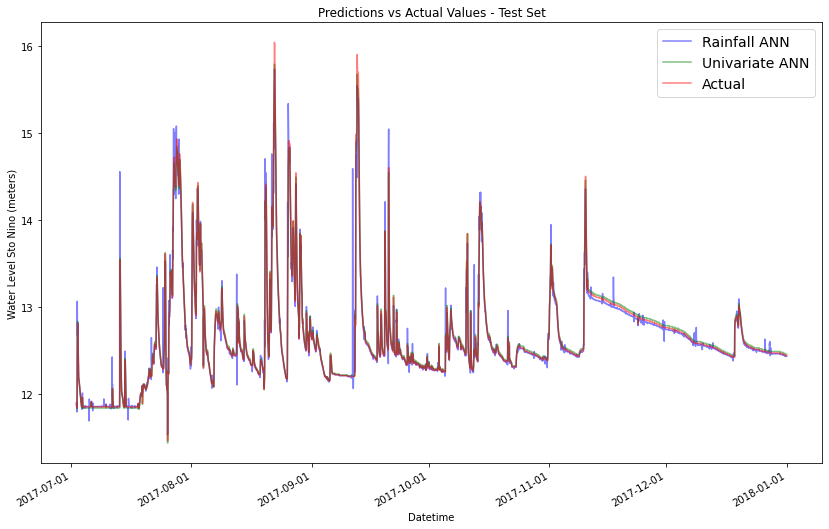

In [80]:
from matplotlib import pyplot as plt
import matplotlib.dates as mdates  # Import the dates module

plt.figure(figsize=(14, 9))  # Adjust the width and height as needed
plt.plot(test_dates, lstm_predictions_multi_ann_rainfall_only, c = "blue", label = "Rainfall ANN", alpha = 0.5)
plt.plot(test_dates, lstm_predictions_univariate_ann, c = "green", label = "Univariate ANN", alpha = 0.5)
#plt.plot(test_dates, lstm_predictions_multi_ann_window_all_inputs, c = "violet", label = "ANN with Saint Venant Inputs", alpha = 0.5)
plt.plot(test_dates, actual, c = "red", label = "Actual", alpha = 0.50)
plt.title('Predictions vs Actual Values - Test Set')
plt.ylabel('Water Level Sto Nino (meters)')
plt.xlabel('Datetime')

# Set x-axis major locator to show ticks for every month
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())

# Format the dates as YYYY-MM-DD
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.gcf().autofmt_xdate()
plt.gca().xaxis_date()
plt.legend(prop={'size': 14})  # Change the size value as needed
plt.show()

In [57]:
lstm_predictions_univariate_ann

array([11.879589 , 11.8582735, 11.836935 , ..., 12.456438 , 12.456438 ,
       12.456438 ], dtype=float32)

In [58]:
lstm_predictions_multi_ann_rainfall_only

array([11.898742, 11.860729, 11.841928, ..., 12.431959, 12.431956,
       12.431954], dtype=float32)

In [59]:
actual

13140    11.89
13141    11.87
13142    11.85
13143    11.84
13144    11.84
         ...  
17515    12.44
17516    12.44
17517    12.44
17518    12.44
17519    12.44
Name: Waterlevel_Sto_Nino, Length: 4380, dtype: float64

In [60]:
test_dates

13140   2017-07-02 12:00:00
13141   2017-07-02 13:00:00
13142   2017-07-02 14:00:00
13143   2017-07-02 15:00:00
13144   2017-07-02 16:00:00
                ...        
17515   2017-12-31 19:00:00
17516   2017-12-31 20:00:00
17517   2017-12-31 21:00:00
17518   2017-12-31 22:00:00
17519   2017-12-31 23:00:00
Name: datetime, Length: 4380, dtype: datetime64[ns]

In [61]:
ann_predictions = pd.DataFrame({
    'Date': test_dates,
    'Actual': actual,
    'Rainfall_ANN': lstm_predictions_multi_ann_rainfall_only,
    'Univariate_ANN': lstm_predictions_univariate_ann
})

In [62]:
ann_predictions

,Date,Actual,Rainfall_ANN,Univariate_ANN
13140,2017-07-02 12:00:00,11.89,11.898742,11.879589
13141,2017-07-02 13:00:00,11.87,11.860729,11.858274
13142,2017-07-02 14:00:00,11.85,11.841928,11.836935
13143,2017-07-02 15:00:00,11.84,11.792230,11.826258
13144,2017-07-02 16:00:00,11.84,12.317009,11.826258
...,...,...,...,...
17515,2017-12-31 19:00:00,12.44,12.431966,12.456438
17516,2017-12-31 20:00:00,12.44,12.431962,12.456438
17517,2017-12-31 21:00:00,12.44,12.431959,12.456438
17518,2017-12-31 22:00:00,12.44,12.431956,12.456438


In [63]:
ann_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4380 entries, 13140 to 17519
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            4380 non-null   datetime64[ns]
 1   Actual          4380 non-null   float64       
 2   Rainfall_ANN    4380 non-null   float32       
 3   Univariate_ANN  4380 non-null   float32       
dtypes: datetime64[ns](1), float32(2), float64(1)
memory usage: 102.8 KB


In [64]:
df_sorted = ann_predictions.sort_values(by='Actual', ascending=False)

# To see the highest actual water levels and corresponding predictions
print("Top 10 highest water levels and their predictions:")
print(df_sorted.head(30))

Top 10 highest water levels and their predictions:
                     Date  Actual  Rainfall_ANN  Univariate_ANN
14361 2017-08-22 09:00:00   16.04     15.731718       15.789402
14362 2017-08-22 10:00:00   16.01     15.699524       15.764717
14360 2017-08-22 08:00:00   15.90     15.590274       15.673782
14871 2017-09-12 15:00:00   15.90     15.544007       15.673782
14363 2017-08-22 11:00:00   15.87     15.572496       15.648865
14872 2017-09-12 16:00:00   15.82     15.375399       15.607224
14877 2017-09-12 21:00:00   15.70     15.401184       15.506714
14878 2017-09-12 22:00:00   15.68     15.383348       15.489886
14364 2017-08-22 12:00:00   15.66     15.386191       15.473032
14876 2017-09-12 20:00:00   15.65     15.360706       15.464597
14359 2017-08-22 07:00:00   15.64     15.554710       15.456157
14873 2017-09-12 17:00:00   15.62     15.391186       15.439260
14879 2017-09-12 23:00:00   15.59     15.306254       15.413871
14875 2017-09-12 19:00:00   15.57     15.300415      

In [70]:
df

,Unnamed: 0,index,Rainfall_Aries,Rainfall_Boso,Rainfall_Campana,Rainfall_Nangka,Rainfall_Oro,Waterlevel_Sto_Nino,Waterlevel_Montalban,Discharge_Sto_Nino,Discharge_San_Jose,Cross_Section_Sto_Nino,Cross_Section_Montalban,Velocity_Sto_Nino,Velocity_Montalban,datetime,t,x
0,0,0,0,1,2,0,0,12.18,21.03,21.033407,14.842428,803.88,630.9,0.026165,0.023526,2016-01-01 00:00:00,0.0,14420
1,1,1,0,1,1,1,0,12.19,21.03,21.280072,14.842428,804.54,630.9,0.026450,0.023526,2016-01-01 01:00:00,3600.0,14420
2,2,2,1,1,1,0,1,12.19,21.03,21.280072,14.842428,804.54,630.9,0.026450,0.023526,2016-01-01 02:00:00,7200.0,14420
3,3,3,0,0,0,1,0,12.20,21.03,21.529056,14.842428,805.20,630.9,0.026738,0.023526,2016-01-01 03:00:00,10800.0,14420
4,4,4,1,1,1,0,0,12.20,21.03,21.529056,14.842428,805.20,630.9,0.026738,0.023526,2016-01-01 04:00:00,14400.0,14420
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17515,17515,16059,0,0,0,0,0,12.44,21.18,28.244204,17.224575,821.04,635.4,0.034401,0.027108,2017-12-31 19:00:00,63140400.0,14420
17516,17516,16424,0,0,0,0,0,12.44,21.18,28.244204,17.224575,821.04,635.4,0.034401,0.027108,2017-12-31 20:00:00,63144000.0,14420
17517,17517,16789,0,0,0,0,0,12.44,21.18,28.244204,17.224575,821.04,635.4,0.034401,0.027108,2017-12-31 21:00:00,63147600.0,14420
17518,17518,17154,0,0,0,0,0,12.44,21.18,28.244204,17.224575,821.04,635.4,0.034401,0.027108,2017-12-31 22:00:00,63151200.0,14420


In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17520 entries, 0 to 17519
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Unnamed: 0               17520 non-null  int64  
 1   index                    17520 non-null  int64  
 2   Rainfall_Aries           17520 non-null  int64  
 3   Rainfall_Boso            17520 non-null  int64  
 4   Rainfall_Campana         17520 non-null  int64  
 5   Rainfall_Nangka          17520 non-null  int64  
 6   Rainfall_Oro             17520 non-null  int64  
 7   Waterlevel_Sto_Nino      17520 non-null  float64
 8   Waterlevel_Montalban     17520 non-null  float64
 9   Discharge_Sto_Nino       17520 non-null  float64
 10  Discharge_San_Jose       17520 non-null  float64
 11  Cross_Section_Sto_Nino   17520 non-null  float64
 12  Cross_Section_Montalban  17520 non-null  float64
 13  Velocity_Sto_Nino        17520 non-null  float64
 14  Velocity_Montalban    

In [73]:
df['datetime'] = pd.to_datetime(df['datetime'])

In [ ]:
import pandas as pd

def parse_data(data_string):
    # Split into rows and parse data
    rows = []
    data = data_string.strip().split('...............')
    
    for entry in data[0].split('\n'):
        if len(entry) >= 30:
            try:
                timestamp = entry[:19]
                values = entry[19:].strip()
                
                actual = float(values[:6])
                predicted1 = float(values[6:14])
                predicted2 = float(values[14:22])
                
                rows.append([timestamp, actual, predicted1, predicted2])
            except:
                continue
    
    return pd.DataFrame(rows, columns=['timestamp', 'actual', 'predicted1', 'predicted2'])


# Filter for date range
start_date = pd.to_datetime('2017-08-22 00:00:00')
end_date = pd.to_datetime('2017-08-23 00:00:00')

filtered_df = df[(df['datetime'] >= start_date) & (df['datetime'] <= end_date)]

# Sort by timestamp and display
filtered_df = filtered_df.sort_values('datetime')


In [75]:
start_date = pd.to_datetime('2017-08-22 00:00:00')
end_date = pd.to_datetime('2017-08-23 00:00:00')

ann_predictions_1 = ann_predictions[(ann_predictions['Date'] >= start_date) & (ann_predictions['Date'] <= end_date)]

In [76]:
ann_predictions_1

,Date,Actual,Rainfall_ANN,Univariate_ANN
14352,2017-08-22 00:00:00,14.11,13.987445,14.097219
14353,2017-08-22 01:00:00,14.24,14.280142,14.217981
14354,2017-08-22 02:00:00,14.33,14.453393,14.301003
14355,2017-08-22 03:00:00,14.50,14.305268,14.456522
14356,2017-08-22 04:00:00,14.93,15.113181,14.842369
14357,2017-08-22 05:00:00,15.20,14.814213,15.079174
14358,2017-08-22 06:00:00,15.39,15.150029,15.243313
14359,2017-08-22 07:00:00,15.64,15.554710,15.456157
14360,2017-08-22 08:00:00,15.90,15.590274,15.673782
14361,2017-08-22 09:00:00,16.04,15.731718,15.789402


In [77]:
start_date = pd.to_datetime('2017-08-22 00:00:00')
end_date = pd.to_datetime('2017-09-22 00:00:00')
ann_predictions_2 = ann_predictions[(ann_predictions['Date'] >= start_date) & (ann_predictions['Date'] <= end_date)]

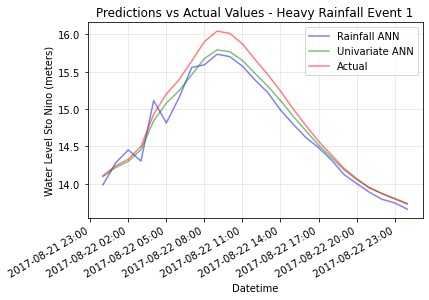

In [78]:
from matplotlib import pyplot as plt
import matplotlib.dates as mdates  # Import the dates module

plt.plot(ann_predictions_1['Date'], ann_predictions_1['Rainfall_ANN'], c = "blue", label = "Rainfall ANN", alpha = 0.5)
plt.plot(ann_predictions_1['Date'], ann_predictions_1['Univariate_ANN'], c = "green", label = "Univariate ANN", alpha = 0.5)
#plt.plot(test_dates, lstm_predictions_multi_ann_window_all_inputs, c = "violet", label = "ANN with Saint Venant Inputs", alpha = 0.5)
plt.plot(ann_predictions_1['Date'], ann_predictions_1['Actual'], c = "red", label = "Actual", alpha = 0.50)
plt.title('Predictions vs Actual Values - Heavy Rainfall Event 1')
plt.ylabel('Water Level Sto Nino (meters)')
plt.xlabel('Datetime')

# Set x-axis to show hourly ticks
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=3))  # Show every hour
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:00'))  # Format as YYYY-MM-DD HH:00

# Rotate and align the tick labels so they look better
plt.gcf().autofmt_xdate()

# Add gridlines for better readability of hourly intervals
plt.grid(True, alpha=0.3)

plt.legend()
plt.show()

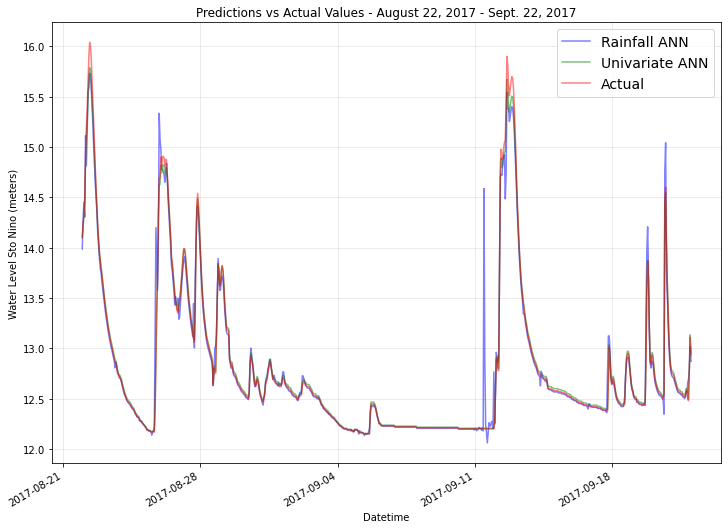

In [81]:
from matplotlib import pyplot as plt
import matplotlib.dates as mdates  # Import the dates module

plt.figure(figsize=(12, 9))  # Adjust the width and height as needed

plt.plot(ann_predictions_2['Date'], ann_predictions_2['Rainfall_ANN'], c = "blue", label = "Rainfall ANN", alpha = 0.5)
plt.plot(ann_predictions_2['Date'], ann_predictions_2['Univariate_ANN'], c = "green", label = "Univariate ANN", alpha = 0.5)
#plt.plot(test_dates, lstm_predictions_multi_ann_window_all_inputs, c = "violet", label = "ANN with Saint Venant Inputs", alpha = 0.5)
plt.plot(ann_predictions_2['Date'], ann_predictions_2['Actual'], c = "red", label = "Actual", alpha = 0.50)
plt.title('Predictions vs Actual Values - August 22, 2017 - Sept. 22, 2017')
plt.ylabel('Water Level Sto Nino (meters)')
plt.xlabel('Datetime')

# Set x-axis to show weekly intervals using AutoDateLocator
locator = mdates.AutoDateLocator(interval_multiples=False)
formatter = mdates.AutoDateFormatter(locator)
plt.gca().xaxis.set_major_locator(locator)
plt.gca().xaxis.set_major_formatter(formatter)

# Rotate and align the tick labels so they look better
plt.gcf().autofmt_xdate()

# Add gridlines for better readability of hourly intervals
plt.grid(True, alpha=0.3)

plt.legend(prop={'size': 14})  # Change the size value as needed
plt.show()